In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path('..').resolve()))

# Examining CNN and U-Net Models through training
Look at the model on some data at different stages during training. The CNN and U-Net training loops are not completely comparable, I'm just giving rough comparisons.

In [9]:
from fontcap_model import UNet, CNNAutoencoder, get_dataloaders, display_reconstructions
import torch
import random

data_root = Path("..") / "data/fonts"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
_, test_loader = get_dataloaders(data_root, batch_size=8, shuffle=True, seed=random.randint(1, 100))

In [ ]:
lower, upper = next(iter(test_loader))
lower = lower.to(device)
upper = upper.to(device)

## CNN: before training

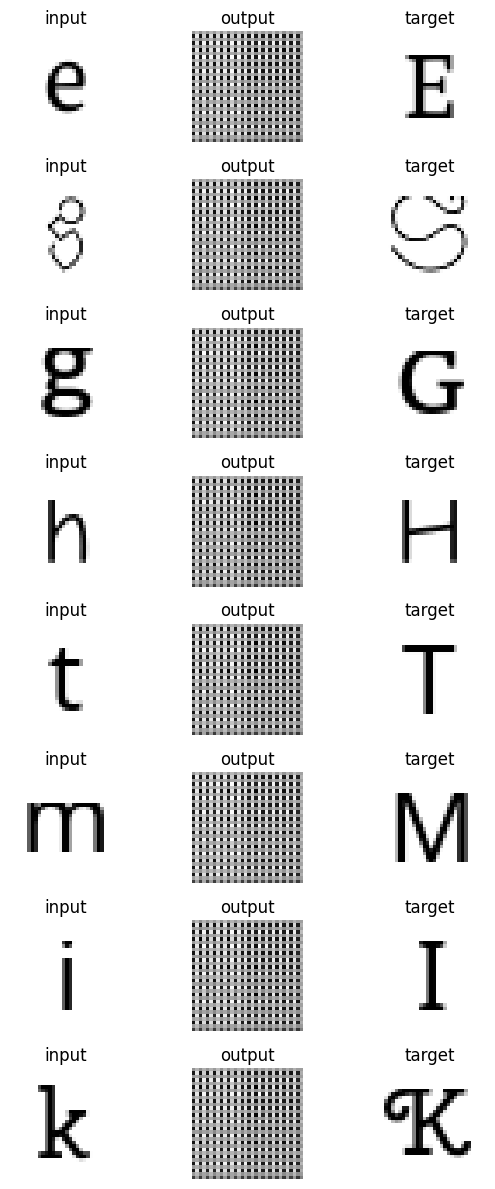

In [11]:
model = CNNAutoencoder().to(device)
model.eval()
_ = display_reconstructions(model, test_loader, device, None, 8)

## U-Net: before training
The outputs of the U-Net before training resemble blurred versions of the inputs because of the side channels.

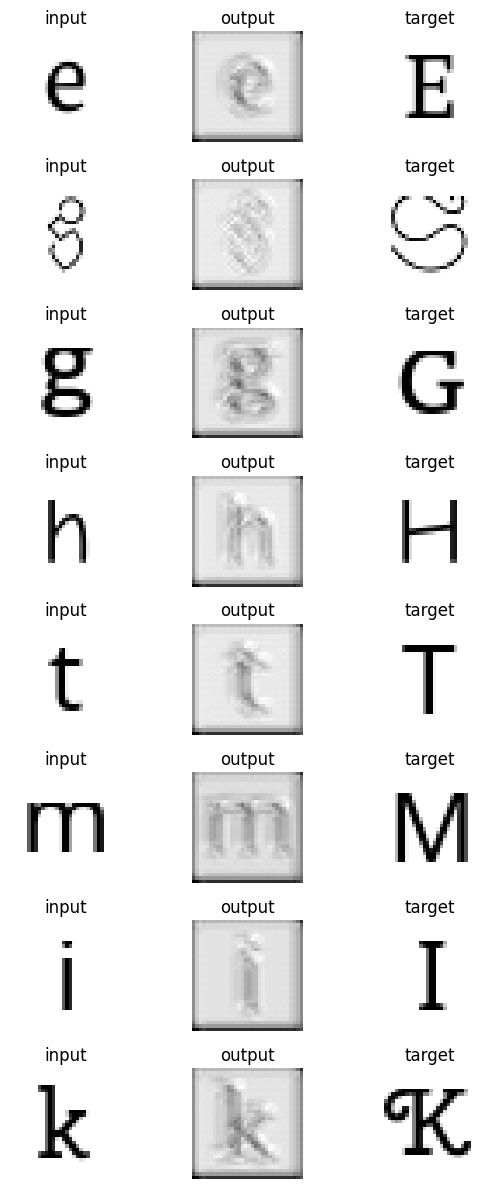

In [15]:
model = UNet().to(device)
model.eval()
_ = display_reconstructions(model, test_loader, device, None, 8)

## CNN after 10 epochs
Much of the coarse-grained structure has been learned!

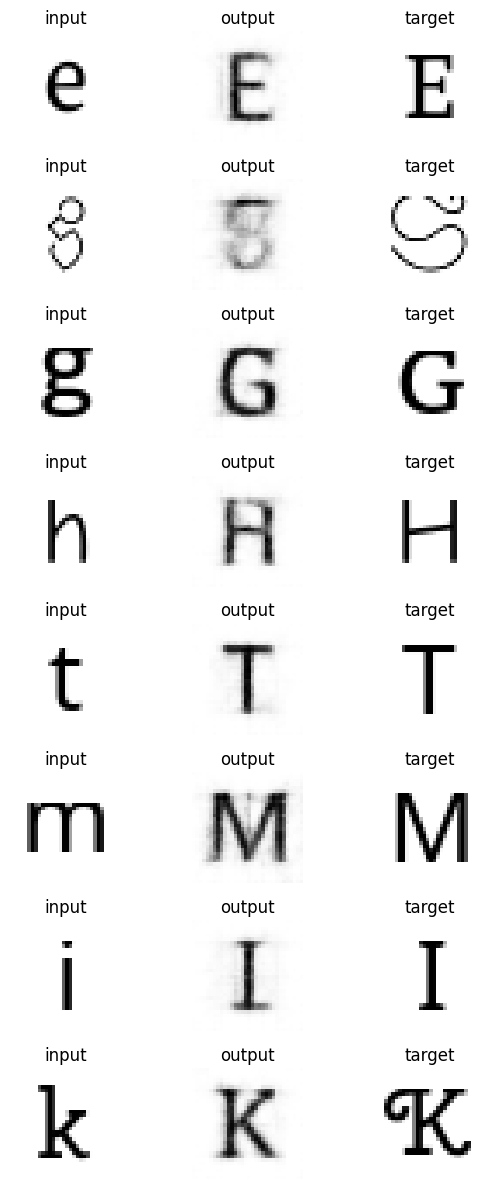

In [12]:
model = CNNAutoencoder().to(device)
model.load_state_dict(torch.load("cnn_10_epochs.pt"))
model.eval()
_ = display_reconstructions(model, test_loader, device, None, 8)

## U-Net after 2 epochs (comparable in terms of training time)

In [ ]:
model = CNNAutoencoder().to(device)
model.load_state_dict(torch.load("cnn_10_epochs.pt"))
model.eval()
_ = display_reconstructions(model, test_loader, device, None, 8)

## CNN after 100 epochs
We have hit a plateau.
 - The model is not learning very fine-grained structure (e.g. cursive fonts, fonts with thin lines)
 - The model test loss is roughly static

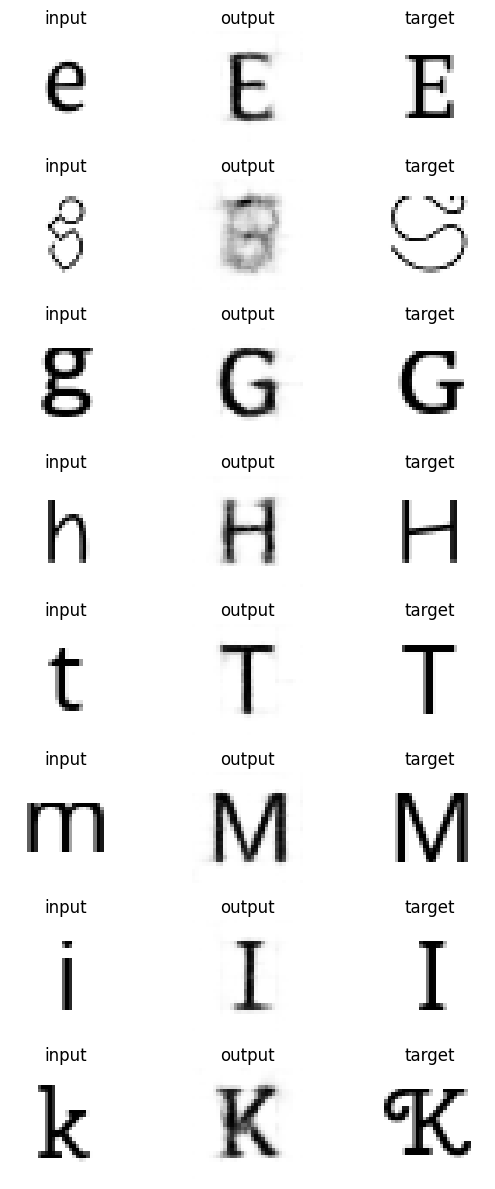

In [14]:
model = CNNAutoencoder().to(device)
model.load_state_dict(torch.load("cnn_100_epochs.pt"))
model.eval()
_ = display_reconstructions(model, test_loader, device, None, 8)

In [ ]:
## U-Net after 

In [ ]:
model = CNNAutoencoder().to(device)
model.load_state_dict(torch.load("cnn_100_epochs.pt"))
model.eval()
_ = display_reconstructions(model, test_loader, device, None, 8)